<a href="https://colab.research.google.com/github/ngjimenez/test_repo/blob/main/Predicting_Bank_Customer_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 1 - Load Data

In [ ]:
# Import
import os 
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

from pandas import to_datetime
import itertools
import warnings
import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score

In [ ]:
raw_df = pd.read_csv('churn raw data.csv')
print(raw_df.shape)
raw_df.head()

(10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Section 2 - Basic Exploration

In [ ]:
raw_df.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [ ]:
for column in raw_df:
    unique_vals = np.unique(raw_df[column])
    num_values = len(unique_vals)
    if num_values < 12:
        print(f'The number of values for feature {column}: {num_values} --> {unique_vals}')
    else:
        print(f'The number of values for feature {column}: {num_values}')

The number of values for feature RowNumber: 10000
The number of values for feature CustomerId: 10000
The number of values for feature Surname: 2932
The number of values for feature CreditScore: 460
The number of values for feature Geography: 3 --> ['France' 'Germany' 'Spain']
The number of values for feature Gender: 2 --> ['Female' 'Male']
The number of values for feature Age: 70
The number of values for feature Tenure: 11 --> [ 0  1  2  3  4  5  6  7  8  9 10]
The number of values for feature Balance: 6382
The number of values for feature NumOfProducts: 4 --> [1 2 3 4]
The number of values for feature HasCrCard: 2 --> [0 1]
The number of values for feature IsActiveMember: 2 --> [0 1]
The number of values for feature EstimatedSalary: 9999
The number of values for feature Exited: 2 --> [0 1]


In [ ]:
raw_df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

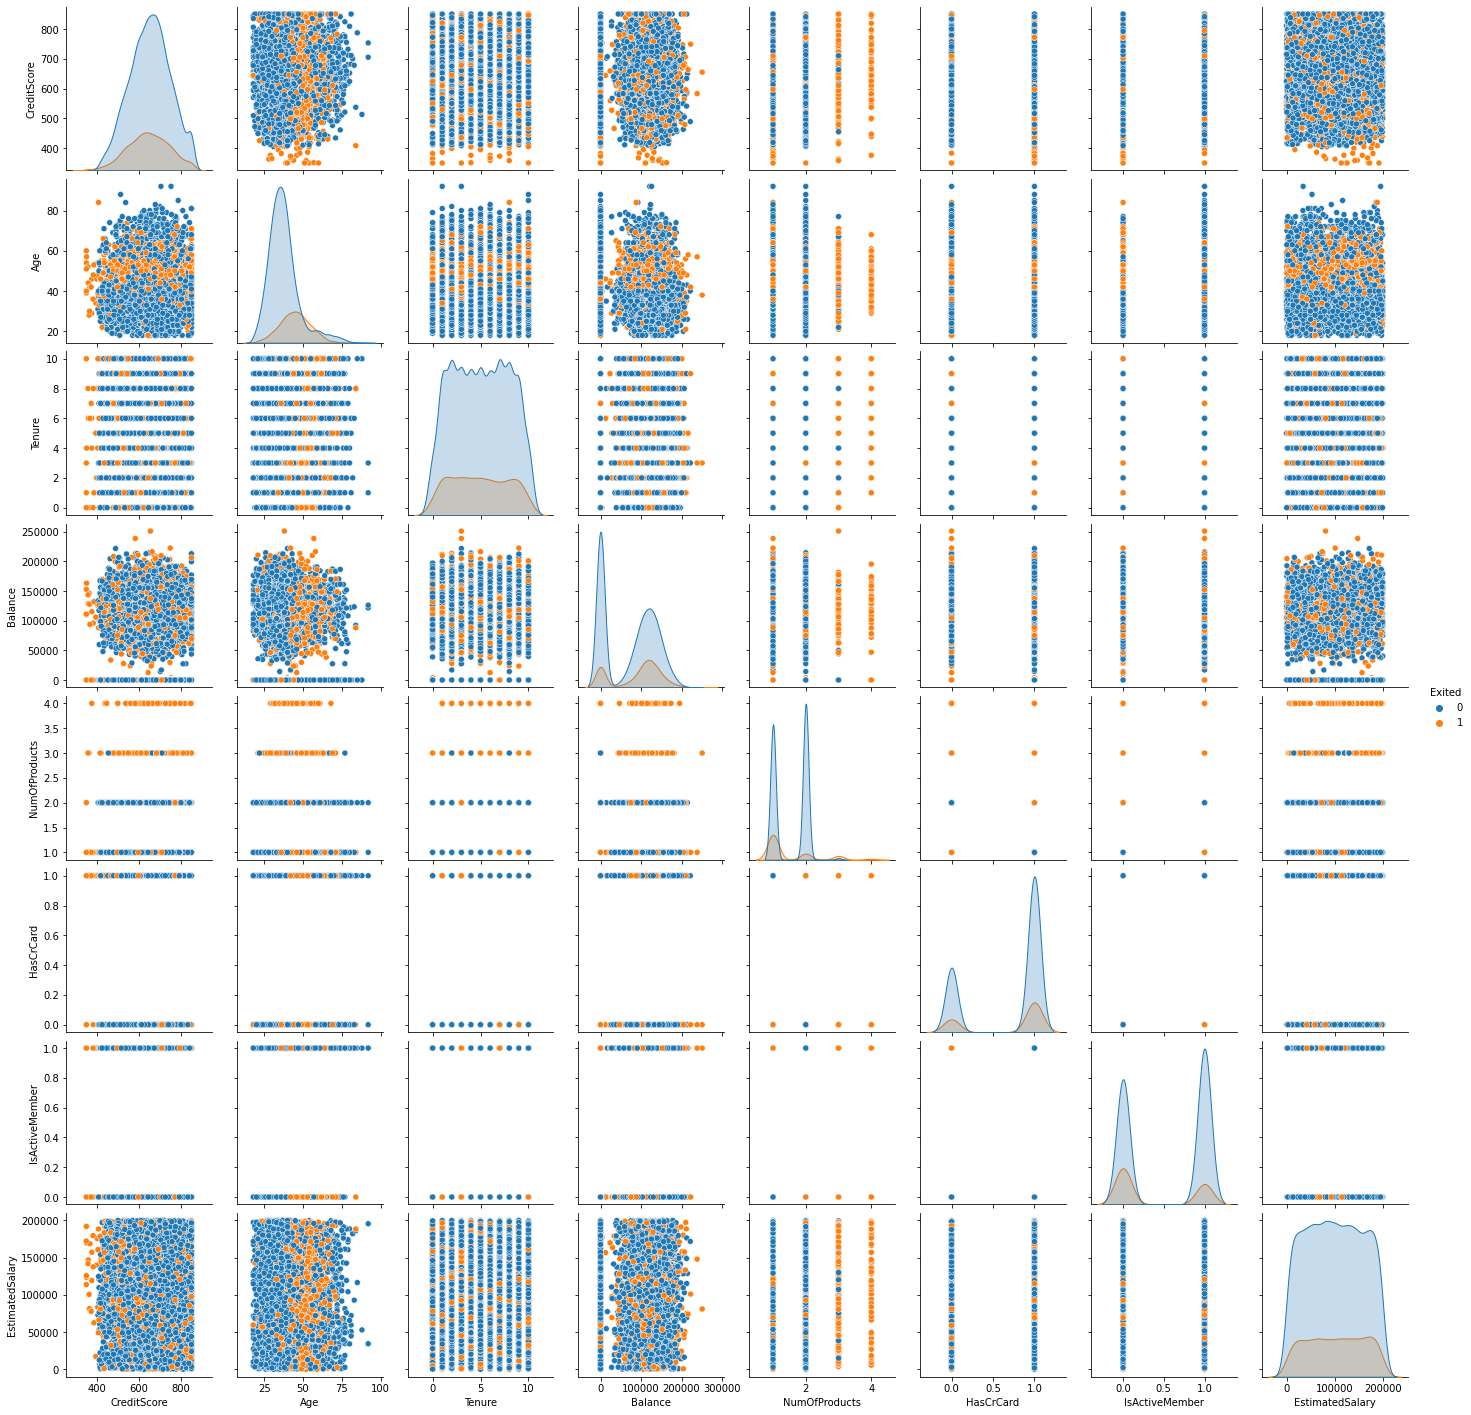

In [ ]:
# Make df of only numeric values
raw_df2 = raw_df[['CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited']]

# Visualize the data using seaborn Pairplots
g = sns.pairplot(raw_df2, hue = 'Exited')    

In the graphic above, we can glean a bit of info. 
* Age vs. Credit Score: those between 40 and 60 are more likely to not churn
* Num prod vs. Age: More products, more churn

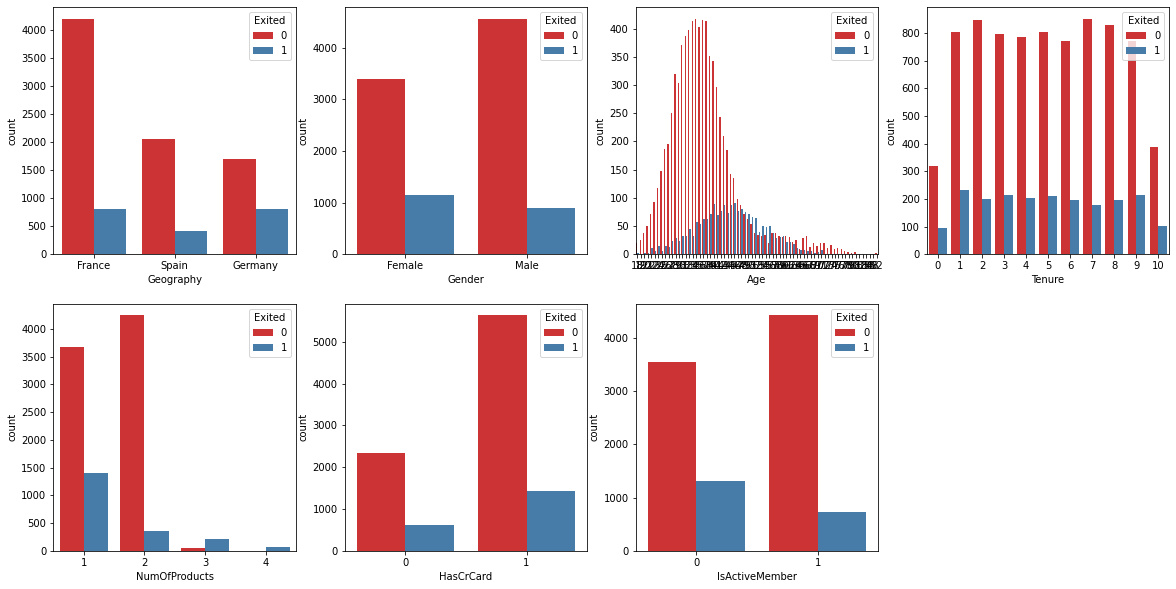

In [ ]:
# Investigate non-numeric features
nrow = 2
ncol = 4
i = 1

plt.subplots(figsize=(20, 10))

features = ['Geography', 'Gender', 'Age', 'Tenure', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember']

for col in features:
    plt.subplot(nrow, ncol, i)
    sns.countplot(x=col, data=raw_df2, hue = 'Exited', palette="Set1")
    i+=1

We have already looked at numeric features, so now we focus on non-numeric features above.
* Age: People who churn have a normal age distribution. People who do not churn have a right skewed distribution.
* Num products: 3 or 4 products shows churn.

In [ ]:
# Convert categorical variables into numeric representations

new_df = pd.get_dummies(raw_df2, columns = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember'])
new_df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1
0,619,42,2,0.00,1,101348.88,1,1,0,0,1,0,0,1,0,1
1,608,41,1,83807.86,1,112542.58,0,0,0,1,1,0,1,0,0,1
2,502,42,8,159660.80,3,113931.57,1,1,0,0,1,0,0,1,1,0
3,699,39,1,0.00,2,93826.63,0,1,0,0,1,0,1,0,1,0
4,850,43,2,125510.82,1,79084.10,0,0,0,1,1,0,0,1,0,1


Above we converted the following columns into dummies:
* Geography - self explanatory

Even the below are numerical, we still want dummies because right now the difference between one and another implies something.
* Gender
* Has Card
* Is Active Member

In [ ]:
# Scaling our columns

scale_vars = ['CreditScore','EstimatedSalary','Balance','Age'] # select which I want to scale
scaler = MinMaxScaler()
new_df[scale_vars] = scaler.fit_transform(new_df[scale_vars])
new_df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1
0,0.538,0.324324,2,0.000000,1,0.506735,1,1,0,0,1,0,0,1,0,1
1,0.516,0.310811,1,0.334031,1,0.562709,0,0,0,1,1,0,1,0,0,1
2,0.304,0.324324,8,0.636357,3,0.569654,1,1,0,0,1,0,0,1,1,0
3,0.698,0.283784,1,0.000000,2,0.469120,0,1,0,0,1,0,1,0,1,0
4,1.000,0.337838,2,0.500246,1,0.395400,0,0,0,1,1,0,0,1,0,1


In [ ]:
# Split data
X = new_df.drop('Exited', axis=1).values# Input features (attributes)
y = new_df['Exited'].values # Target vector
print('X shape: {}'.format(np.shape(X)))
print('y shape: {}'.format(np.shape(y)))

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.9, test_size=0.1, random_state=0)

X shape: (10000, 15)
y shape: (10000,)


# Section 3: Models

## Section 3.1 - Decision Tree

### Section 3.1.1 - The Tree

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=1)
dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=1)

[Text(0.5, 0.8333333333333334, 'Age <= 0.318\nentropy = 0.729\nsamples = 9000\nvalue = [7169, 1831]\nclass = 1'),
 Text(0.25, 0.5, 'NumOfProducts <= 2.5\nentropy = 0.507\nsamples = 6130\nvalue = [5442, 688]\nclass = 1'),
 Text(0.125, 0.16666666666666666, 'entropy = 0.464\nsamples = 5998\nvalue = [5407, 591]\nclass = 1'),
 Text(0.375, 0.16666666666666666, 'entropy = 0.834\nsamples = 132\nvalue = [35, 97]\nclass = 0'),
 Text(0.75, 0.5, 'IsActiveMember_1 <= 0.5\nentropy = 0.97\nsamples = 2870\nvalue = [1727, 1143]\nclass = 1'),
 Text(0.625, 0.16666666666666666, 'entropy = 0.989\nsamples = 1313\nvalue = [576, 737]\nclass = 0'),
 Text(0.875, 0.16666666666666666, 'entropy = 0.828\nsamples = 1557\nvalue = [1151, 406]\nclass = 1')]

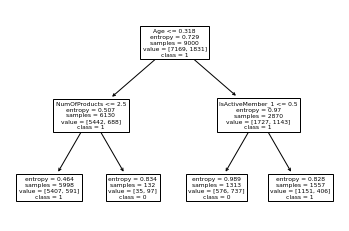

In [ ]:
tree.plot_tree(dt, feature_names = new_df.drop('Exited', axis=1).columns, 
                class_names=new_df['Exited'].unique().astype(str))

### Section 3.1.2 - Calculate Feature Importance

In [ ]:
# Calculate fx importance
for i, column in enumerate(new_df.drop('Exited', axis=1)):
    print('Importance of feature {}:, {:.3f}'.format(column, dt.feature_importances_[i]))
    
    fi = pd.DataFrame({'Variable': [column], 'Feature Importance Score': [dt.feature_importances_[i]]})
    
    try:
        final_fi = pd.concat([final_fi,fi], ignore_index = True)
    except:
        final_fi = fi
        
        
# Ordering the data
final_fi = final_fi.sort_values('Feature Importance Score', ascending = False).reset_index()            
final_fi

Importance of feature CreditScore:, 0.000
Importance of feature Age:, 0.622
Importance of feature Tenure:, 0.000
Importance of feature Balance:, 0.000
Importance of feature NumOfProducts:, 0.196
Importance of feature EstimatedSalary:, 0.000
Importance of feature Geography_France:, 0.000
Importance of feature Geography_Germany:, 0.000
Importance of feature Geography_Spain:, 0.000
Importance of feature Gender_Female:, 0.000
Importance of feature Gender_Male:, 0.000
Importance of feature HasCrCard_0:, 0.000
Importance of feature HasCrCard_1:, 0.000
Importance of feature IsActiveMember_0:, 0.000
Importance of feature IsActiveMember_1:, 0.182


,index,Variable,Feature Importance Score
0,1,Age,0.622346
1,4,NumOfProducts,0.195552
2,14,IsActiveMember_1,0.182102
3,0,CreditScore,0.000000
4,2,Tenure,0.000000
5,3,Balance,0.000000
6,5,EstimatedSalary,0.000000
7,6,Geography_France,0.000000
8,7,Geography_Germany,0.000000
9,8,Geography_Spain,0.000000


In [ ]:
# Accuracy on Train
print("Training Accuracy is: ", dt.score(X_train, y_train))

# Accuracy on Train
print("Testing Accuracy is: ", dt.score(X_test, y_test))

Training Accuracy is:  0.8213333333333334
Testing Accuracy is:  0.822


### Section 3.1.3 - Metrics

In [ ]:
# Confusion Matrix function

def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True, annot_kws={'size':20})
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

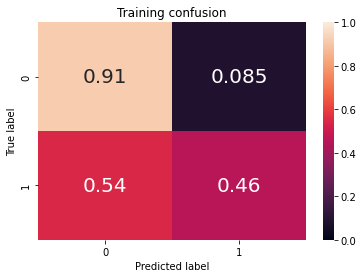

In [ ]:
y_pred = dt.predict(X_train)

# Plot Confusion Matrix
cm = confusion_matrix(y_train, y_pred)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=dt.classes_, title='Training confusion')

In [ ]:
y_pred = dt.predict(X_train)
y_pred
confusion_matrix(y_train, y_pred)

array([[6558,  611],
       [ 997,  834]], dtype=int64)

In [ ]:
# Calculating False Positives (FP), False Negatives (FN), True Positives (TP) & True Negatives (TN)
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)


# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print ("The True Positive rate / Recall per class is: ",TPR)

# Precision or positive predictive value
PPV = TP/(TP+FP)
print ("The Precision per class is: ",PPV)

# False positive rate or False alarm rate
FPR = FP/(FP+TN)
print ("The False Alarm rate per class is: ",FPR)

# False negative rate or Miss Rate
FNR = FN/(TP+FN)
print ("The Miss Rate rate per class is: ",FNR)

# Classification error
CER = (FP+FN)/(TP+FP+FN+TN)
print ("The Classification error of each class is", CER)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print ("The Accuracy of each class is", ACC)
print("")

##Total averages :
print ("The average Recall is: ",TPR.sum()/2)
print ("The average Precision is: ",PPV.sum()/2)
print ("The average False Alarm is: ",FPR.sum()/2)
print ("The average Miss Rate rate is: ",FNR.sum()/2)
print ("The average Classification error is", CER.sum()/2)
print ("The average Accuracy is", ACC.sum()/2)

The True Positive rate / Recall per class is:  [0.91477193 0.4554888 ]
The Precision per class is:  [0.86803441 0.57716263]
The False Alarm rate per class is:  [0.5445112  0.08522807]
The Miss Rate rate per class is:  [0.08522807 0.5445112 ]
The Classification error of each class is [0.17866667 0.17866667]
The Accuracy of each class is [0.82133333 0.82133333]

The average Recall is:  0.685130369325603
The average Precision is:  0.7225985220264771
The average False Alarm is:  0.31486963067439694
The average Miss Rate rate is:  0.31486963067439694
The average Classification error is 0.17866666666666667
The average Accuracy is 0.8213333333333334


## Section 3.2 - Random Forest

### Section 3.2.1 - Running RF

Training Accuracy is:  0.9998888888888889
Testing Accuracy is:  0.867


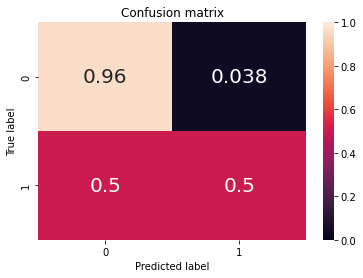

In [ ]:
rf = RandomForestClassifier(n_estimators=100, criterion='entropy') #estimators = num trees
rf.fit(X_train, y_train)
prediction_test = rf.predict(X=X_test)

# Accuracy on Test
print("Training Accuracy is: ", rf.score(X_train, y_train))
# Accuracy on Train
print("Testing Accuracy is: ", rf.score(X_test, y_test))

# Confusion Matrix
cm = confusion_matrix(y_test, prediction_test)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=rf.classes_)

Good at predicting who does NOT churn, but we want it to be good at predicting who WILL churn so we can catch them early and focus on keeping them. 

### Section 3.2.2 - Tuning the Random Forest

Classification accuracy on test set with max features = 1 and max_depth = None: 0.860
Classification accuracy on test set with max features = 1 and max_depth = 2: 0.794
Classification accuracy on test set with max features = 1 and max_depth = 3: 0.794
Classification accuracy on test set with max features = 1 and max_depth = 4: 0.797
Classification accuracy on test set with max features = 1 and max_depth = 5: 0.802
Classification accuracy on test set with max features = sqrt and max_depth = None: 0.868
Classification accuracy on test set with max features = sqrt and max_depth = 2: 0.800
Classification accuracy on test set with max features = sqrt and max_depth = 3: 0.812
Classification accuracy on test set with max features = sqrt and max_depth = 4: 0.831
Classification accuracy on test set with max features = sqrt and max_depth = 5: 0.850
Classification accuracy on test set with max features = log2 and max_depth = None: 0.868
Classification accuracy on test set with max features = log2

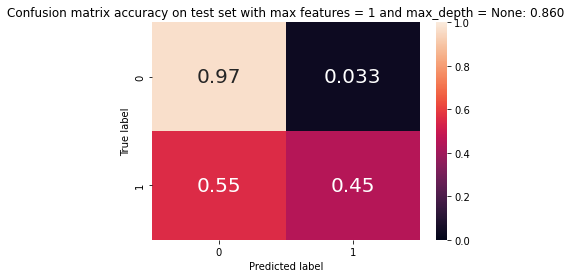

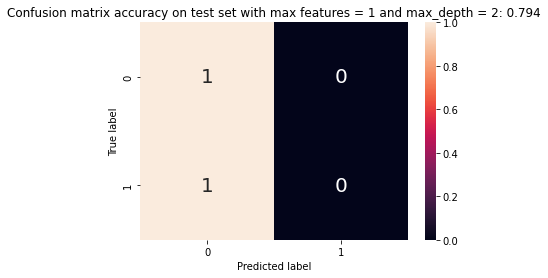

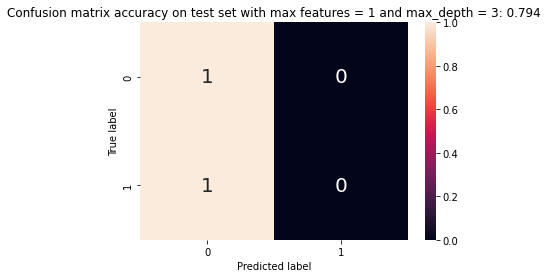

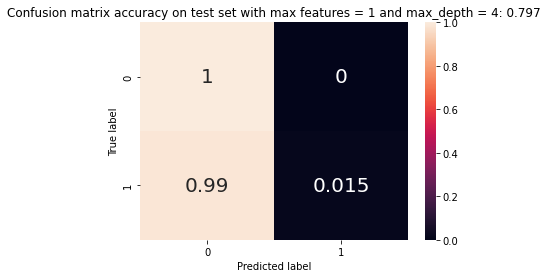

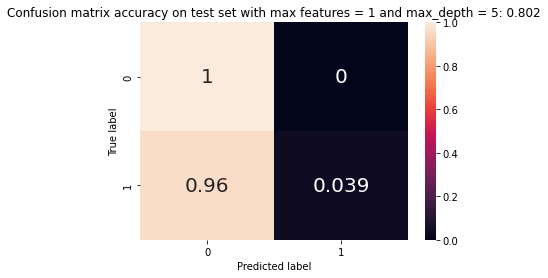

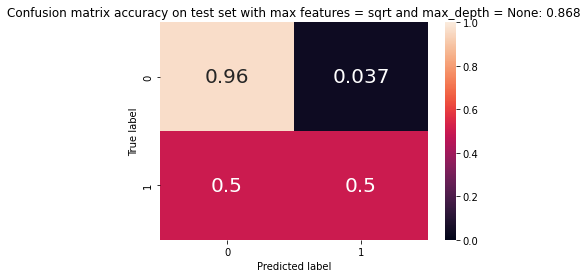

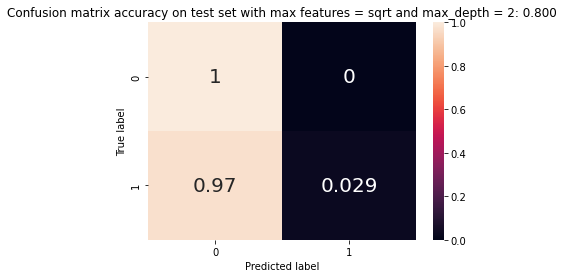

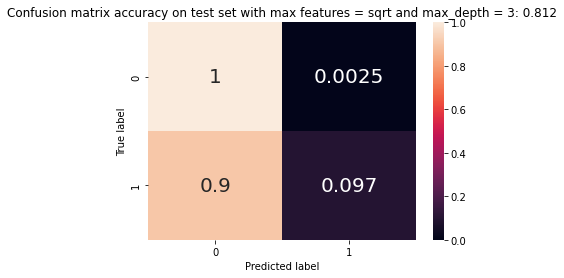

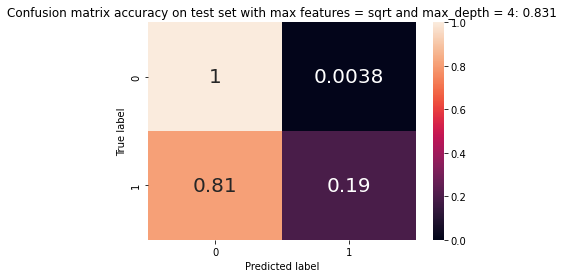

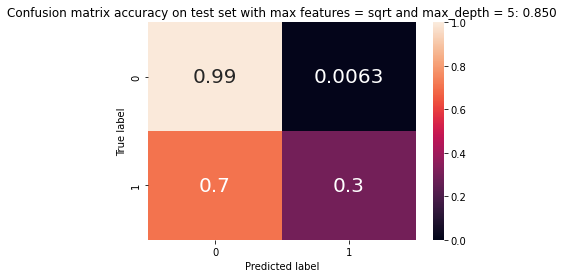

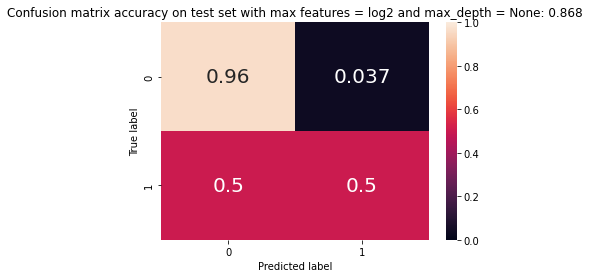

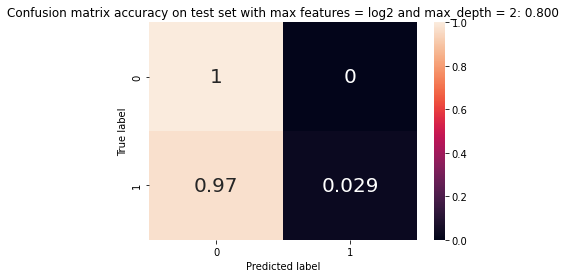

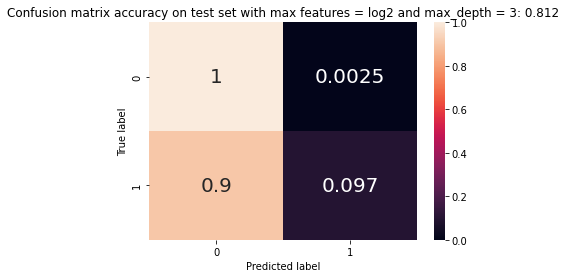

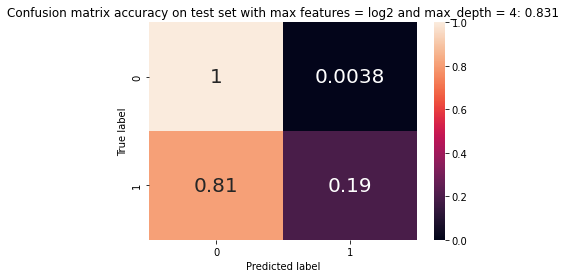

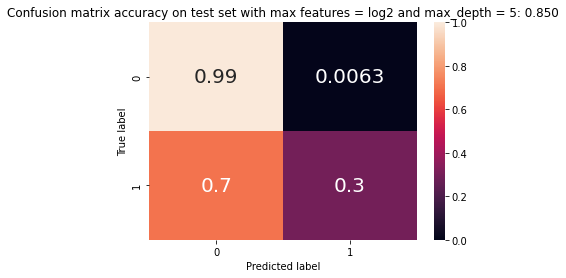

In [ ]:
from itertools import product #product to run combo of max_feat and max_depths
n_estimators = 100
max_features = [1, 'sqrt', 'log2']
max_depths = [None, 2, 3, 4, 5]
for f, d in product(max_features, max_depths): # with product we can iterate through all possible combinations
    rf = RandomForestClassifier(n_estimators=n_estimators, 
                                criterion='entropy', 
                                max_features=f, 
                                max_depth=d, 
                                n_jobs=2,
                                random_state=1337)
    rf.fit(X_train, y_train)
    prediction_test = rf.predict(X=X_test)
    print('Classification accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(f, d, accuracy_score(y_test,prediction_test)))
    cm = confusion_matrix(y_test, prediction_test)
    cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plot_confusion_matrix(cm_norm, classes=rf.classes_,
    title='Confusion matrix accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(f, d, accuracy_score(y_test,prediction_test)))

The best parameters are:
* max_feat = sqrt
* max_depth = None

## Section 3.3 - XGBoost